<a href="https://colab.research.google.com/github/Machine-Learning-Tokyo/MLT-x-fastai/blob/master/mini-lessons/text/gpt2_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.text import *

In [0]:
path = untar_data(URLs.IMDB_SAMPLE)

In [0]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


We'll looking a little bit at this [library](https://huggingface.co/pytorch-transformers/) for state-of-the-art NLP models

In [0]:
#!pip install pytorch_transformers
from pytorch_transformers import *

In [0]:
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_tokenizer.save_vocabulary(".")

('./vocab.json', './merges.txt')

In [0]:
EOS = BOS = gpt2_tokenizer.all_special_tokens[0]
#defaults.text_post_rules = []
#defaults.text_pre_rules = [fix_html]

In [0]:
class GPTFastaiTokenizer(BaseTokenizer):
    "Basic class for a tokenizer function."
    def __init__(self, lang:str): self.lang = lang
    def tokenizer(self, t:str) -> List[str]:           
        return gpt2_tokenizer.tokenize(t)
    def add_special_cases(self, toks:Collection[str]): pass

In [0]:
itos_json = json.load(open("vocab.json"))
itos = [k for v,k in enumerate(itos_json)]

In [0]:
tokenizer = GPTFastaiTokenizer("en")
processor = [TokenizeProcessor(Tokenizer(tokenizer)),NumericalizeProcessor(vocab=Vocab(itos))]

In [0]:
class GPT2LMWrapper(GPT2LMHeadModel):
    def __init__(self, config):
        super(GPT2LMHeadModel, self).__init__(config)
        self.transformer = GPT2Model(config)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.apply(self.init_weights)
        self.tie_weights()

    def tie_weights(self):
        """ Make sure we are sharing the input and output embeddings.
            Export to TorchScript can't handle parameter sharing so we are cloning them instead.
        """
        self._tie_or_clone_weights(self.lm_head,
                                   self.transformer.wte)
    
    def reset(self):pass
    
    def forward(self, input_ids, position_ids=None, token_type_ids=None, labels=None, past=None, head_mask=None):
        transformer_outputs = self.transformer(input_ids, position_ids=position_ids, token_type_ids=token_type_ids,
                                               past=past, head_mask=head_mask)
        hidden_states = transformer_outputs[0]

        lm_logits = self.lm_head(hidden_states)

        outputs = (lm_logits,) + transformer_outputs + transformer_outputs
        if labels is not None:
            # Shift so that tokens < n predict n
            shift_logits = lm_logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            # Flatten the tokens
            loss_fct = CrossEntropyLoss(ignore_index=-1)
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)),
                            shift_labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), lm_logits, presents, (all hidden_states), (attentions)

In [0]:
model = GPT2LMWrapper.from_pretrained('gpt2')

In [0]:
from fastai.callbacks import *

In [0]:
data_lm = (TextList.from_df(df,path,cols="text",processor=processor)
             .split_by_rand_pct()
             .label_for_lm()
             .databunch())

In [0]:
data_lm.show_batch()

idx,text
0,"! ! ! ! ! this was directed by the guy who did ! big ! ! ? ! must be a ! of ! ! - ! style . ! ! ! ! ! this is a extremely well - made film . ! the acting , script and camera - work are all first - rate . ! the music is good , too , though it is"
1,/ 2 hours . i expected more about ! son of ! sam and instead got a movie that ! to have very little to do with the 1977 serial ! . ! the talking dog was ! ( you know you 're in ! when all the movie ! burst into laughter ! ) . ! the ! movie ! very ! and not very interesting . ! the
2,"series ! it a ! telling ! to the ! . ! ! , ! ! ! is a pretty "" modern "" girl when you think about it , even though the ! of ! ! ! ! 's world may ! a ! ! to us today . ! if you have ! ! ! ! , i 'll only say that self - sufficient ! ! does"
3,", particularly the use of ! or ! on head and ! hair . ! ! this film is the only one that ! with some ! ! ! ' original ! ! as has been ! . ! ! may find it ! to note plot details that ! here that are ! ! in other versions of the story . ! ! ' description of the ! !"
4,"! once wrote about that , "" we should all try to hang around with ! of other ! and try to know them . "" ! ! you 're ! your own ! . ! ! ! ! ! in one of those ! i ! . ! one time someone put ! around campus talking about the ! of the ! ! ! race and had the !"


In [0]:
learn = LanguageLearner(data_lm,model)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


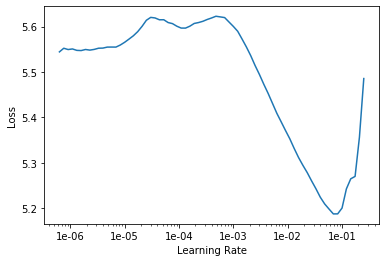

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(15,3e-3,moms=(0.7,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,4.842220,4.403178,0.281824,00:57
1,4.287532,3.765579,0.314429,00:57
2,3.825458,3.423177,0.345966,00:57
3,3.545260,3.327716,0.357733,00:57
4,3.352965,3.245280,0.363361,00:57
5,3.226402,3.210527,0.366980,00:57
6,3.125595,3.181285,0.369834,00:57
7,3.046173,3.167163,0.372082,00:57
8,3.001789,3.164754,0.372130,00:57


In [0]:
learn.predict("I liked this movie because",n_words=70)